In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['.ipynb_checkpoints', '__MACOSX', 'plates', 'submission.csv', '__notebook_source__.ipynb']


In [38]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', '.DS_Store', 'test']


In [39]:
import shutil 
from tqdm import tqdm_notebook as tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [40]:
!ls train

cleaned  dirty


In [41]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
plt.style.use('dark_background')
from torchvision import transforms, models

aug_lvl_1 = transforms.Compose([              
    transforms.RandomHorizontalFlip(p=0.75),                                
    transforms.TenCrop(224, vertical_flip=True),
    transforms.Lambda(
        lambda crops: torch.stack([aug_lvl_2(crop) for crop in crops]))
])    


aug_lvl_2 = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(1.0, 0.3, 0.3, 0.5),
        transforms.RandomRotation(360),
        transforms.RandomResizedCrop(size=(224,224),scale=(0.6, 1.0))
    ], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(
        lambda x: x[np.random.permutation(3), :, :])                            
])



In [42]:
train_transforms = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.TenCrop(224),
    transforms.Lambda(
        lambda crops: torch.stack([aug_lvl_1(crop) for crop in crops]))
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms)
])
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [43]:
def create_target_set(variable, size_target, dtype = torch.long): #Эта функия нужна, чтобы "размножить" метки. 

    target = torch.tensor([variable], dtype = dtype, requires_grad=False)
    target = torch.nn.functional.pad(target,
                                     (size_target//2, size_target//2 - 1),
                                     "constant",
                                     variable)
    
    return target

def augmentation(dir_data, dir_transforms, batch_size, shuffle, num_workers):  #Ключевая функция в данном решении. Она позволяет
                                                                               #40 картинок получить 4000 тензоров!
    data = []
    target = []

    #Создание набора данных
    dataset = train_dataset #torchvision.datasets.ImageFolder(dir_data, dir_transforms)

    #Изменение размерностей тензоров и "размножение" меток
    for dt, trgt in tqdm(dataset):
        data.append(dt.resize_(100, 3, 224, 224))
        target.append(create_target_set(trgt, 100))

    #Объединение тензоров
    dtst = list(
        zip(torch.cat(data , dim = 0), torch.cat(target, dim = 0))
        )
    
    #Создание dataloader
    dataloader = torch.utils.data.DataLoader(
        dtst,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers = num_workers
        )
    
    return dataloader

In [8]:
batch_size = 8

train_dataloader = augmentation(
    train_dir,
    train_transforms,
    batch_size = batch_size,
    shuffle = True,
    num_workers = batch_size
    )

In [9]:
len(train_dataloader), len(train_dataset)

(1200, 96)

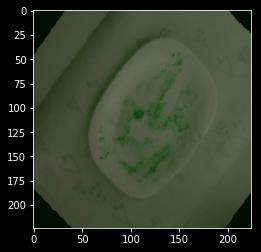

In [10]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[6].permute(1, 2, 0).numpy() * std + mean);

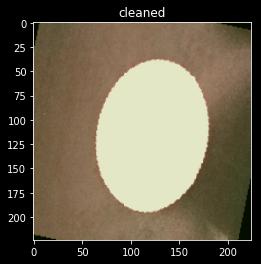

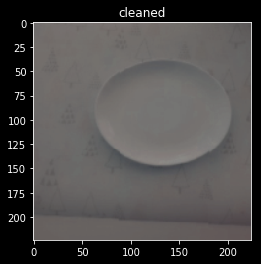

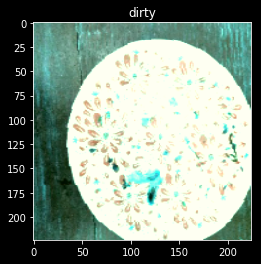

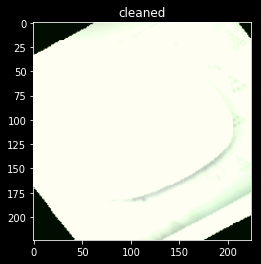

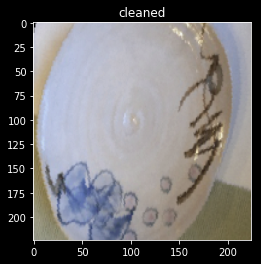

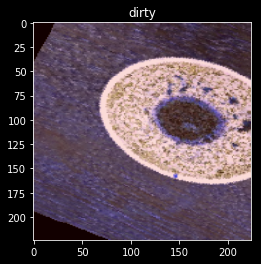

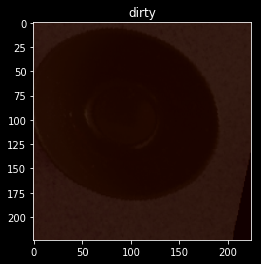

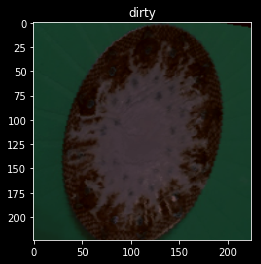

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            if phase == 'train':
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_loss.append(epoch_loss)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, train_loss, val_loss

In [19]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4, weight_decay=0.6)#, momentum=0.9, weight_decay=0.2)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model,train_loss,val_loss = train_model(model, loss, optimizer, scheduler, num_epochs=8);

Epoch 0/7:


train Loss: 0.5007 Acc: 0.7689


val Loss: 0.4923 Acc: 0.8750
Epoch 1/7:


train Loss: 0.4413 Acc: 0.8134


val Loss: 0.4529 Acc: 1.0000
Epoch 2/7:


train Loss: 0.4361 Acc: 0.8208


val Loss: 0.5043 Acc: 0.6250
Epoch 3/7:


train Loss: 0.4359 Acc: 0.8165


val Loss: 0.4673 Acc: 0.7500
Epoch 4/7:


train Loss: 0.4347 Acc: 0.8177


val Loss: 0.4499 Acc: 0.8750
Epoch 5/7:


train Loss: 0.4314 Acc: 0.8219


val Loss: 0.5048 Acc: 0.7500
Epoch 6/7:


train Loss: 0.4206 Acc: 0.8365


val Loss: 0.4819 Acc: 1.0000
Epoch 7/7:


train Loss: 0.4256 Acc: 0.8338


val Loss: 0.4471 Acc: 1.0000


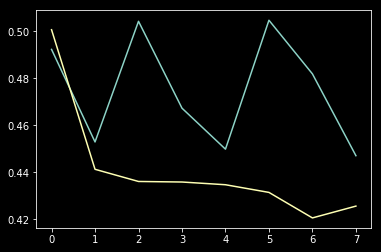

In [44]:
plt.plot(val_loss)
plt.plot(train_loss)

In [45]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [46]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [47]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [48]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

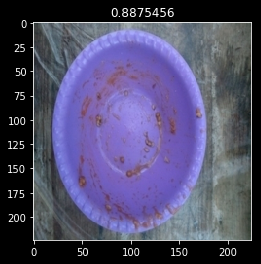

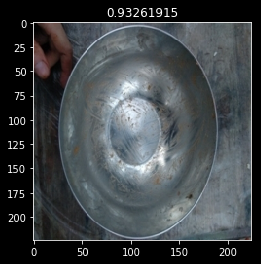

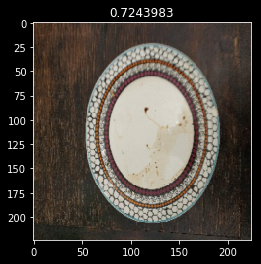

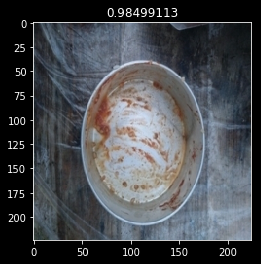

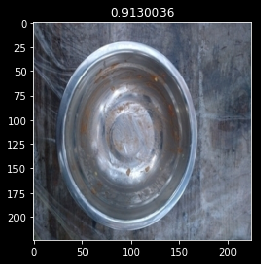

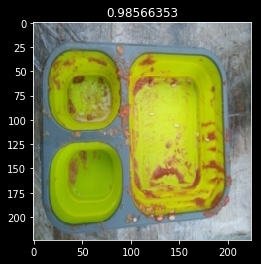

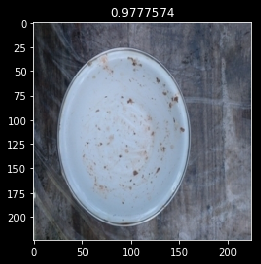

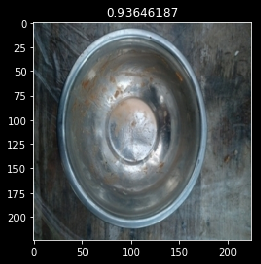

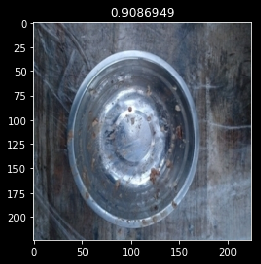

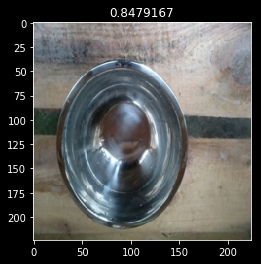

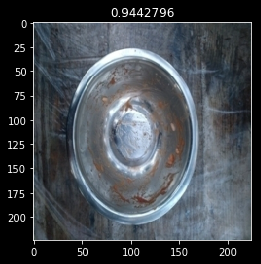

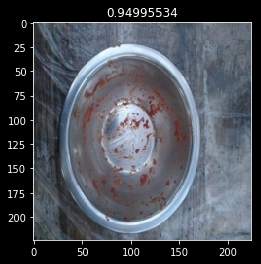

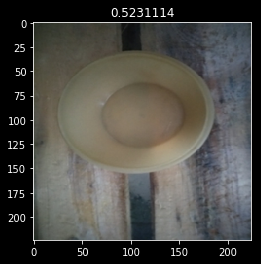

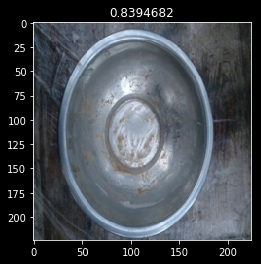

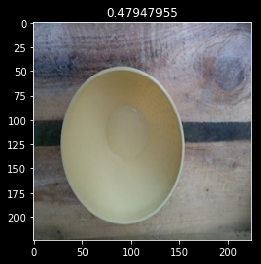

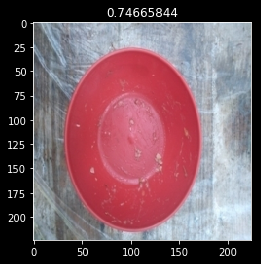

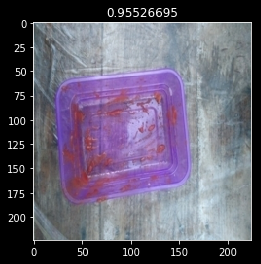

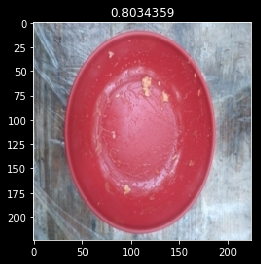

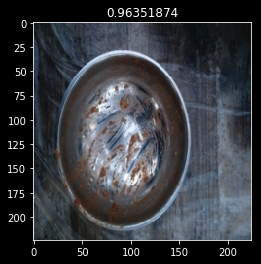

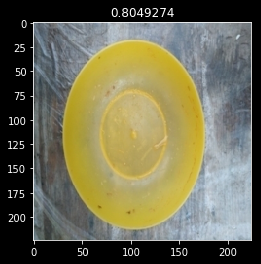

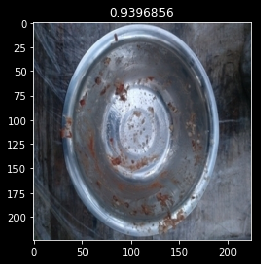

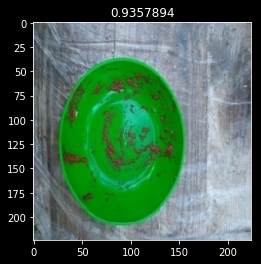

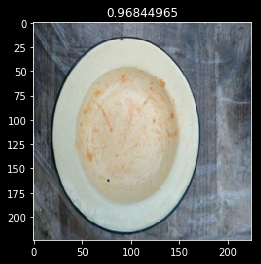

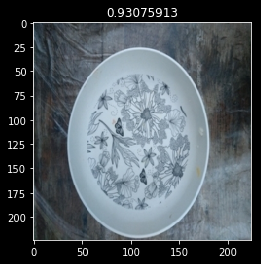

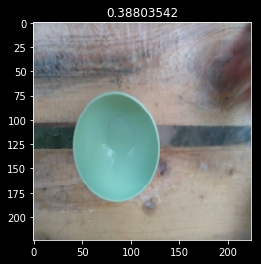

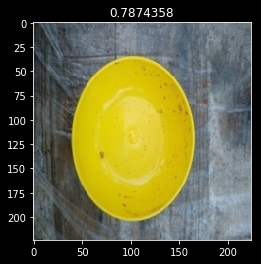

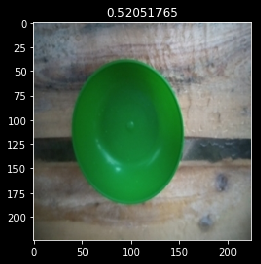

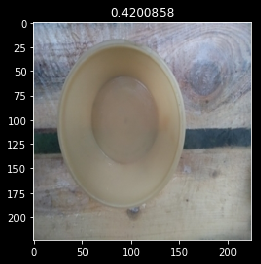

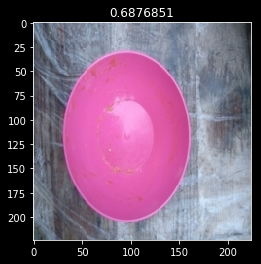

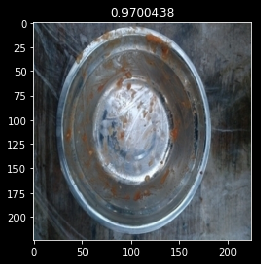

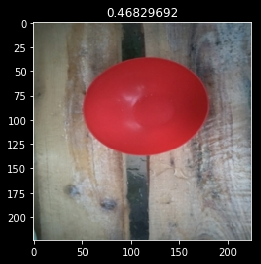

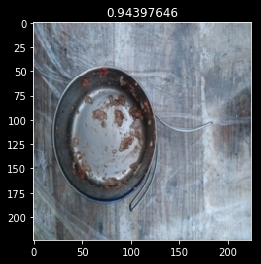

In [55]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [65]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [62]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.785 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [63]:
submission_df.to_csv('submission.csv')

In [30]:
!rm -rf train val test

In [64]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
#df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(submission_df, filename='submission.csv')
